In [1]:
import keras
from keras import regularizers, optimizers
from keras import losses
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence

from keras.layers import Conv1D, Flatten, Activation, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
from sklearn.metrics import confusion_matrix, roc_auc_score,precision_recall_curve
from sklearn.metrics import classification_report,auc

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Using TensorFlow backend.


Python:  3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
pandas:  0.23.4
numpy:  1.19.1
seaborn:  0.9.0
matplotlib:  2.2.3
sklearn:  0.19.2
Keras:  2.3.1
Tensorflow:  2.1.0


In [2]:
df = pd.read_csv("../data/occupancy.txt", sep=",", index_col=None)
#dt = pd.read_csv("art_daily_jumpsdown.csv", sep=",", index_col=None)
print(df.shape)
pd.options.display.max_columns = None
df.head(5)

(2380, 2)


,timestamp,value
0,2015-09-01 13:45:00,3.06
1,2015-09-01 13:50:00,6.44
2,2015-09-01 13:55:00,5.17
3,2015-09-01 14:00:00,3.83
4,2015-09-01 14:05:00,4.50


In [3]:
df.tail(5)

,timestamp,value
2375,2015-09-17 16:04:00,9.28
2376,2015-09-17 16:09:00,5.06
2377,2015-09-17 16:14:00,3.44
2378,2015-09-17 16:19:00,8.50
2379,2015-09-17 16:24:00,5.56


In [3]:
train=df[df['value']<6]
train=train['value']
train=np.array(train)
timesquence=10
trim=len(train)%timesquence
train=train[:len(train)-trim]
train.shape=(int(len(train)/timesquence),timesquence,1)
print("train",train.shape)


train (175, 10, 1)


In [4]:
test=df['value']
test_label=[]
abnormal=0
normal=0
for i in range(len(test)):
    if(test.iloc[i]>15 ):
        test_label.append(1)
        test.iloc[i]=test.iloc[i]+20
        normal+=1
    else:
        abnormal+=1
        test_label.append(0)
            
    
print(len(test_label))
test=np.array(test)
trim=len(test)%timesquence
test_label=test_label[:len(test)-trim]
test=test[:len(test)-trim]
test.shape=(int(len(test)/timesquence),timesquence,1)

F:\anaconda\anac\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2380


In [10]:
from keras.layers import  Lambda
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 
# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq
for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
              kernel_regularizer=regularizers.l2(0.02),
               padding='causal',
               dilation_rate=dilation_rate,activation='relu')(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)
# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]
pred_seq_train = Lambda(slice, arguments={'seq_length':timesquence})(x)

TCN = Model(history_seq, pred_seq_train)
TCN.compile(optimizer=optimizers.Adam(), loss='mean_absolute_error')
TCN.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          96        
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 32)          2080

In [11]:
from keras.callbacks import TensorBoard
tensorboard=tensorflow.keras.callbacks.TensorBoard(histogram_freq=1)
history=TCN.fit(train, train,
          batch_size=2**10,
           epochs=90,#84
          validation_data=(test, test))
         # callbacks = [tensorboard])


Train on 175 samples, validate on 238 samples
Epoch 1/90
175/175 [==============================] - 7s 40ms/step - loss: 7.3566 - val_loss: 9.1879
Epoch 2/90
175/175 [==============================] - 1s 3ms/step - loss: 7.3031 - val_loss: 9.1266
Epoch 3/90
175/175 [==============================] - 1s 3ms/step - loss: 7.2421 - val_loss: 9.0621
Epoch 4/90
175/175 [==============================] - 1s 3ms/step - loss: 7.1780 - val_loss: 8.9960
Epoch 5/90
175/175 [==============================] - 1s 3ms/step - loss: 7.1124 - val_loss: 8.9289
Epoch 6/90
175/175 [==============================] - 1s 3ms/step - loss: 7.0454 - val_loss: 8.8611
Epoch 7/90
175/175 [==============================] - 1s 3ms/step - loss: 6.9780 - val_loss: 8.7929
Epoch 8/90
175/175 [==============================] - 1s 3ms/step - loss: 6.9100 - val_loss: 8.7243
Epoch 9/90
175/175 [==============================] - 1s 3ms/step - loss: 6.8418 - val_loss: 8.6555
Epoch 10/90
175/175 [==============================] 

Epoch 82/90
175/175 [==============================] - 1s 3ms/step - loss: 2.2414 - val_loss: 2.7234
Epoch 83/90
175/175 [==============================] - 1s 3ms/step - loss: 2.2082 - val_loss: 2.6245
Epoch 84/90
175/175 [==============================] - 1s 3ms/step - loss: 2.1624 - val_loss: 2.5509
Epoch 85/90
175/175 [==============================] - 1s 3ms/step - loss: 2.1080 - val_loss: 2.5033
Epoch 86/90
175/175 [==============================] - 0s 3ms/step - loss: 2.0640 - val_loss: 2.4766
Epoch 87/90
175/175 [==============================] - 1s 3ms/step - loss: 2.0135 - val_loss: 2.4539
Epoch 88/90
175/175 [==============================] - 1s 3ms/step - loss: 1.9671 - val_loss: 2.4048
Epoch 89/90
175/175 [==============================] - 1s 3ms/step - loss: 1.9332 - val_loss: 2.3125
Epoch 90/90
175/175 [==============================] - 1s 3ms/step - loss: 1.8791 - val_loss: 2.1847


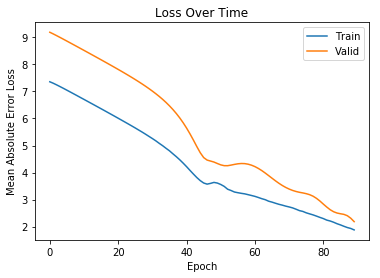

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [13]:
test_pred = TCN.predict(test)
print(test_pred.shape)
# print(test[0:5])
# print("-------------------------")
# print(test_pred[0:5])


(238, 10, 1)


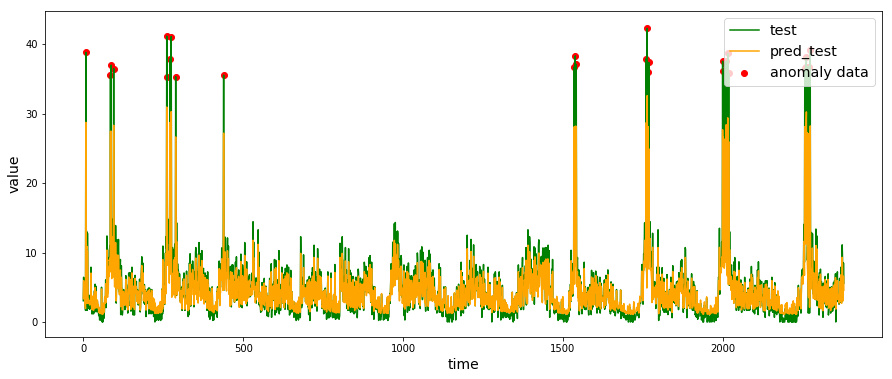

In [14]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(10)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,2)
plt.plot(test1[0:],color="green")
plt.plot(test_pred1[0:],color="orange",linestyle='-')
for i in range(len(test1)):
    if test_label[i] == 1:
        plt.scatter(i,test1[i],color="red")          
plt.legend(('test','pred_test','anomaly data'),loc='upper right',fontsize='x-large')


In [57]:
#点集检测
pred_label=[]
for i in range(len(test1)):
    pred_label.append(0)#正常

PAsum_rela_erro=np.zeros((len(pred_label)), dtype = float)
for i in range(len(pred_label)):
    PAsum_rela_erro[i]=np.abs(test1[i]-test_pred1[i])
PAscores=PAsum_rela_erro.copy()
PAscores.sort()
print(PAscores)


[2.40654945e-04 4.82721329e-04 7.63626099e-04 ... 1.08138994e+01
 1.09308948e+01 1.24450919e+01]


In [58]:
print(PAscores[500])

0.23401946067810053


In [59]:
PAcutoff=int(0.985*len(PAscores))
PAthreshold=PAscores[PAcutoff]
print(PAscores[PAcutoff])

4.58875015258789


In [60]:
for i in range(len(test1)):
    if PAsum_rela_erro[i] > PAthreshold:
        pred_label[i]=2 #异常

In [61]:
normal_rela_erro=0.15
#集体集检测
timestep=6
n=int(len(pred_label)/timestep)
CAsum_rela_erro=np.zeros(n+1, dtype = float)
for i in range(0,len(test1),timestep):
    for j in range(timestep):
            if ((i+j)<len(pred_label)) and (pred_label[i+j]==0):
                rela_erro=np.abs(test1[i+j]-test_pred1[i+j])
                CAsum_rela_erro[int(i/timestep)]=rela_erro+CAsum_rela_erro[int(i/timestep)]
              #  print()
            else:
                CAsum_rela_erro[int(i/timestep)]=normal_rela_erro+CAsum_rela_erro[int(i/timestep)]
                
                
CAscores=CAsum_rela_erro.copy()
CAscores.sort()
print(CAscores)


[ 0.74140732  0.78101382  0.87211905  0.88052413  1.01454557  1.03160454
  1.04694319  1.08205931  1.16731175  1.31423736  1.34420016  1.34604527
  1.37969981  1.39630162  1.41427824  1.43280931  1.43790186  1.44994833
  1.53405219  1.53408433  1.55473859  1.55867542  1.57381094  1.57619281
  1.59006089  1.59528544  1.61160729  1.66537448  1.70783009  1.71584786
  1.74066705  1.74770501  1.74870438  1.77886353  1.79099313  1.79975822
  1.80487803  1.81155498  1.81923976  1.84357058  1.85621809  1.85700969
  1.85951493  1.86941567  1.88176903  1.89337434  1.89785374  1.90234126
  1.90284115  1.94040388  1.94108103  1.94408098  1.97110271  1.97110483
  1.99823698  2.03826093  2.04995802  2.0710621   2.08702163  2.09435781
  2.10048299  2.11035038  2.11938206  2.12599251  2.1362503   2.13849457
  2.15000685  2.15202712  2.16498031  2.17930401  2.18044531  2.18113396
  2.18602811  2.18715068  2.19182265  2.22390853  2.24244808  2.24609208
  2.24737851  2.26403103  2.2649066   2.26701598  2

In [63]:
CAcutoff=int(0.99*len(CAscores))
CAthreshold=24#CAscores[CAcutoff]
print(CAthreshold)

24


In [64]:
for i in range(n+1):
    if CAsum_rela_erro[i] > CAthreshold:
        for j in range(timestep):
            if i*timestep+j<len(pred_label) and pred_label[i*timestep+j]!=2:
                pred_label[i*timestep+j]=1
        

In [65]:
Perro_x=[]
Perro_y=[]
Cerro_x=[]
Cerro_y=[]
for i in range(len(test1)):
    if pred_label[i]==2:
        Perro_x.append(i)
        Perro_y.append(test1[i])
    elif pred_label[i]==1:
        Cerro_x.append(i)
        Cerro_y.append(test1[i])

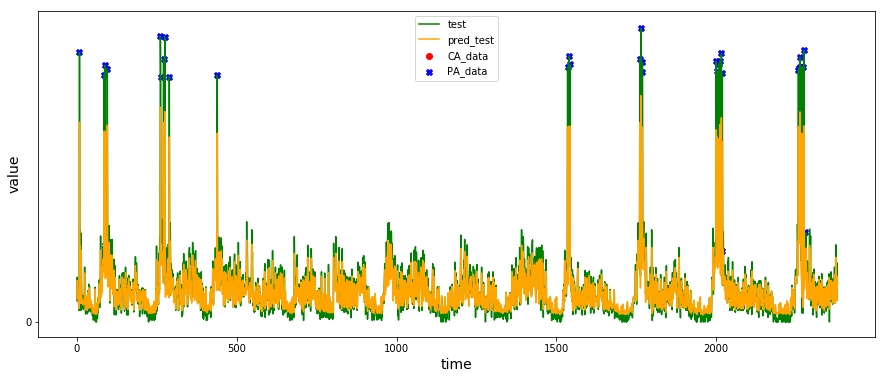

In [66]:
from matplotlib.pyplot import MultipleLocator
test1=test.reshape(test.shape[0]*test.shape[1],1)
test_pred1=test_pred.reshape(test_pred.shape[0]*test_pred.shape[1],1)
plt.figure(figsize=(15,6))
plt.xlabel('time',fontsize=14)
plt.ylabel('value',fontsize=14)
y_major_locator=MultipleLocator(100)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
#plt.ylim(0,1000)
plt.plot(test1[0:],color="green",label='test')
plt.plot(test_pred1[0:],color="orange",linestyle='-',label='pred_test')
plt.scatter(Cerro_x,Cerro_y,color="red",label='CA_data')
plt.scatter(Perro_x,Perro_y,color="blue",marker="X",label='PA_data')          
plt.legend()


In [67]:
Pred_label=[]
for i in range(len(pred_label)):
    if pred_label[i]==0:
        Pred_label.append(0)
    else:
        Pred_label.append(1)

In [68]:
print("CA:",pred_label.count(1))
print("PA:",pred_label.count(2))
ROC=roc_auc_score(test_label,Pred_label)
print("ROC_AUC score:{:2%}".format(ROC))  
precision, recall, _thresholds = precision_recall_curve(test_label, Pred_label)
PR_AUC = auc(recall, precision)
print("PR-AUC score:{:2%}".format(PR_AUC)) 

CA: 0
PA: 35
ROC_AUC score:99.893617%
PR-AUC score:92.857143%


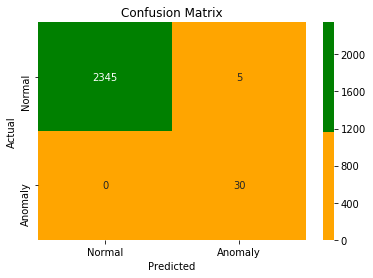

In [69]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(6, 4))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

viz = Visualization()
viz.draw_confusion_matrix(test_label,Pred_label)